In [1]:
%matplotlib inline

# Import math tools
import numpy as np

# Import the tools to handle general Graphs
import networkx as nx

# Import miscellaneous tools
import pprint as pp

# Import plotting tools
import pandas as pd
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Import Qiskit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.providers.aer import QasmSimulator
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram, plot_state_city

# Import tools for running QAOA
import random
from scipy.optimize import minimize, fmin, Bounds
from sympy.combinatorics.graycode import GrayCode

In [2]:
from qiskit import IBMQ
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

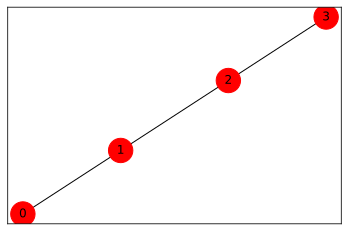

In [3]:
# Line
# {"0": [1], "1": [0,2], "2": [1,3], "3": [2]}
n     = 4
V     = np.arange(0,n,1)
E     =[(0,1),(1,2),(2,3)] 

G     = nx.Graph()
G.add_nodes_from([(vertex, {'color' : None}) for vertex in V])
G.add_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

plt.show()

In [4]:
def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

In [5]:
def color_graph_num(graph, num_color, root):
    color_index = 0
    not_allowed_color = []

    # Mark all the vertices as not visited
    visited = {x: False for x in graph.nodes}

    # Create a queue for BFS
    queue = []

    # Mark the source node as
    # visited and enqueue it
    queue.append(root)
    visited[root] = True

    while queue:
        # Dequeue a vertex from queue and color it
        source = queue.pop(0)
        not_allowed_color = [graph.nodes[neighbour]['color'] for neighbour in graph[source] 
                                if (graph.nodes[neighbour]['color'] != None 
                                    and graph.nodes[neighbour]['color'] < num_color) ]
        while color_index in not_allowed_color:
            color_index = (color_index+1)%num_color
        G.nodes[source]['color'] = color_index
        not_allowed_color = []

        # Get all adjacent vertices of the
        # dequeued vertex s. If a adjacent
        # has not been visited, then mark it
        # visited and enqueue it
        for i in graph[source]:
            if visited[i] == False:
                queue.append(i)
                visited[i] = True

    return

In [6]:
def color_graph_coloring(graph, coloring):
    for index,node in enumerate(graph.nodes):
        graph.nodes[node]['color'] = coloring[index]
    
    return

In [7]:
# Graph Information
print("Graph information")

coloring = [G.nodes[node]['color'] for node in G.nodes]
print("\nPre-coloring", coloring)

degree = [deg for (node, deg) in G.degree()]
print("\nDegree of each node", degree)

num_colors = max(degree)+2
print("\nNumber of colors", num_colors)

node_list = list(G.nodes)
color_graph_num(G, num_colors, node_list[0])

for i in G.nodes:
    print("\nNode",i,"Color", G.nodes[i]['color'])
    neighbours = [G.nodes[neighbour]['color'] for neighbour in G[i]]
    print("Neighbours Colors", neighbours)

coloring = [G.nodes[node]['color'] for node in G.nodes]
print("\nInitial coloring", coloring)

Graph information

Pre-coloring [None, None, None, None]

Degree of each node [1, 2, 2, 1]

Number of colors 4

Node 0 Color 0
Neighbours Colors [1]

Node 1 Color 1
Neighbours Colors [0, 2]

Node 2 Color 2
Neighbours Colors [1, 3]

Node 3 Color 3
Neighbours Colors [2]

Initial coloring [0, 1, 2, 3]


In [69]:
class QAOAMinGraphColoring:

    def __init__(self, p, graph, num_colors):
        # Parameter p of QAOA
        # Number of times the operators are applied
        self.p = p
        
        # Inital number of colors, usually graph's degree+2
        self.num_colors = num_colors

        # The graph is a Graph object from networkx
        self.graph = graph

        # Number of vertices in the graph
        self.num_nodes = self.graph.number_of_nodes()

        # Qiskit circuit initialization
        self.circuit = QuantumCircuit((self.num_nodes*self.num_colors)+self.num_nodes,
                (self.num_nodes*self.num_colors)+self.num_nodes)

        # Variable of run results
        self.job = None
        self.results = []

    # Compute the value of the cost function
    # Count the number of USED colors
    def cost_function(self, x, G, num_colors):
        C = 0
        for color in range(num_colors):
            color_used = 0
            for node in G.nodes():
                if x[node*num_colors + color] == 1:
                    color_used = 1
                    break
            C += color_used
            
        return C

    # Create the complete QAOA circuit
    # using parameters gamma and beta
    def create_circuit(self, gamma, beta0, beta):
        # Initial state preparation
        self.initial_state()

        # Alternate application of operators
        self.mixer(beta0) # Mixer 0
        for step in range(self.p):
            self.phase_separator(gamma[step])
            self.mixer(beta[step])

        # Measurement
        self.measurement()

    # Run QAOA circuit in Qiskit
    def run(self,
            backend = Aer.get_backend('qasm_simulator'),
            backend_options = {"method" : "statevector_gpu"},
            shots = 1000,
            optimization_level = 2):
        # Execute the circuit on the selected backend
        optimized = transpile(self.circuit, backend=backend, seed_transpiler=11, optimization_level=optimization_level)

        self.job = execute(optimized, backend, shots=shots, backend_options=backend_options)
        # Grab results from the job
        result = self.job.result()
        counts = result.get_counts()

        for sample in list(counts.keys()):
            sample_coloring = []
            list_qubits = sample[::-1]

            # Restoring coloring from qubit values
            for i in range(len(self.graph)):
                for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
                    if int(char):
                        # node color == pos
                        sample_coloring.append(pos)

            # use sampled bit string x to compute C(x)
            x         = [int(num) for num in list_qubits]
            tmp_eng   = self.cost_function(x,self.graph,self.num_colors)
            
            self.results.append((counts[sample], list_qubits, sample_coloring, tmp_eng))
        
        self.results.sort(reverse=True)

    # Return how long lasted the last run 
    def time(self):
        if self.job == None:
            self.run()
        # Grab results from the job
        result = self.job.result()
        print("Time taken: {} sec".format(result.time_taken))
    
    # Pretty Print all results obtained in the last run
    def show_results(self):
        if self.job == None:
            self.run()
        print("Counts, Bit Values, Coloring, C(x)")
        pp.pprint(self.results)

    def number_of_gates(self,
                        backend = Aer.get_backend('qasm_simulator')):
        qc = self.circuit
        soma  = 0
        soma0 = 0
        soma1 = 0
        soma2 = 0
        soma3 = 0

        print('Original Circuit')
        print('gates = ', qc.count_ops())
        for i in qc.count_ops():
            soma += qc.count_ops()[i]
        print('total gates = ', soma)
        print('depth = ', qc.depth())

        print('\nOptmization 0')
        optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
        print('gates = ', optimized_0.count_ops())
        for i in optimized_0.count_ops():
            soma0 += optimized_0.count_ops()[i]
        print('total gates = ', soma0)
        print('depth = ', optimized_0.depth())

        print('\nOptmization 1')
        optimized_1 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=1)
        print('gates = ', optimized_1.count_ops())
        for i in optimized_1.count_ops():
            soma1 += optimized_1.count_ops()[i]
        print('total gates = ', soma1)
        print('depth = ', optimized_1.depth())

        print('\nOptmization 2')
        optimized_2 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=2)
        print('gates = ', optimized_2.count_ops())
        for i in optimized_2.count_ops():
            soma2 += optimized_2.count_ops()[i]
        print('total gates = ', soma2)
        print('depth = ', optimized_2.depth())

        print('\nOptmization 3')
        optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
        print('gates = ', optimized_3.count_ops())
        for i in optimized_3.count_ops():
            soma3 += optimized_3.count_ops()[i]
        print('total gates = ', soma3)
        print('depth = ', optimized_3.depth())

    # Controlled Rz rotation for phase_separation and toffoli
    # The target qubit will always be the last one of the qubits
    # in the vector 'qubits'
    def cRz(self, qubits, gamma):
        num_qubits = len(qubits)
        qubits_t = qubits[1:]
        exp = np.power(2, num_qubits-1)
        a = GrayCode(num_qubits)
        gray_list = list(a.generate_gray())[1:]

        # Add the necessary gates following the Gray Code
        self.circuit.u1(gamma/exp, qubits[0])
        self.circuit.cx(qubits[0], qubits[1])
        counter = 1
        for i, node in enumerate(qubits_t):
            for j in range(np.power(2, i+1)-1):
                self.circuit.u1(np.power(-1, counter)*gamma/exp, node)
                counter += 1
                codes = zip(gray_list[counter-1][::-1], gray_list[counter][::-1])
                enumerator = 0
                for u,v in codes:
                    if u != v:
                        self.circuit.cx(qubits[enumerator], node)
                    enumerator += 1
            if i < len(qubits_t)-1:
                self.circuit.u1(np.power(-1, counter)*gamma/exp, node)
                counter += 1
                self.circuit.cx(node, qubits_t[i+1])
        self.circuit.u1(np.power(-1, counter)*gamma/exp, qubits_t[-1])

    # N-qubit controlled Toffoli gate
    # implemented using the cRz gate and changing
    # the base of the target qubit using Hadamard
    def toffoli(self, controls, target):
        all_qubits = controls+[target]
        self.circuit.h(target)
        self.cRz(all_qubits, np.pi)
        self.circuit.h(target)

    def find_sequence(self, pos_b, start):
        sequence = []
        end = pos_b[start]
        while end != start:
            sequence.append(end)
            end = pos_b[end]

        sequence.append(start)
        return sequence

    # Rearrange the qubit order so that qubits
    # representing the same color stay adjacent to each other
    def qubits2color(self):
        qdit_ord = []
        color_ord = []
        for i in range(self.num_nodes):
            for j in range(self.num_colors):
                pos_a = i*self.num_colors+j
                pos_b = j*self.num_nodes+i
                qdit_ord.append(pos_a)
                color_ord.append(pos_b)

        not_visited = set(qdit_ord)

        while not_visited:
            index = next(iter(not_visited))
            sequence = self.find_sequence(color_ord, index)

            for pos in sequence:
                not_visited.remove(pos)

            if len(sequence) != 1:
                start = sequence.pop()
                while sequence:
                    qubit_b = sequence.pop()
                    self.circuit.swap(qubit_b, start)
                    start = qubit_b
    
    # Rearrange the qubit order so that qubits
    # representing the colors of the same node stay adjacent to each other
    def color2qubits(self):
        qdit_ord = []
        color_ord = []
        for i in range(self.num_nodes):
            for j in range(self.num_colors):
                pos_a = i*self.num_colors+j
                pos_b = j*self.num_nodes+i
                qdit_ord.append(pos_a)
                color_ord.append(pos_b)

        not_visited = set(qdit_ord)

        while not_visited:
            index = next(iter(not_visited))
            sequence = self.find_sequence(color_ord, index)

            for pos in sequence:
                not_visited.remove(pos)

            if len(sequence) != 1:
                start = sequence.pop(0)
                while sequence:
                    qubit_b = sequence.pop(0)
                    self.circuit.swap(qubit_b, start)
                    start = qubit_b


    # Prepare the initial state of QAOA
    # Add a X gate to color the vertices following the one-hot notation
    def initial_state(self):
        coloring = [self.graph.nodes[node]['color'] for node in self.graph.nodes]
        for i, color in enumerate(coloring):
            self.circuit.x((i*self.num_colors)+color)
        return
    
    # First rearrange the order of the qubits so every color is adjacent to each other
    # Uses a controlled-Rz operation with a negative control to count the number of used colors
    # Order the qubits again so the qudits are in the right place
    def phase_separator(self, gamma):
        self.qubits2color()
        #self.circuit.barrier()
        for node in range(self.num_colors*self.num_nodes):
           self.circuit.x(node)
        for k in range(self.num_colors):
            qubits = [k*self.num_nodes+node for node in range(self.num_nodes)]
            self.cRz(qubits, 2*gamma)
        for node in range(self.num_colors*self.num_nodes):
            self.circuit.x(node)
        #self.circuit.barrier()
        self.color2qubits()
        #self.circuit.barrier()


    # Apply a controlled XX-YY rotation in the qubits representig the colors
    # i and j if none of the nodes in the neighbourhood are colored either i or j
    def partial_mixer(self, neighbour, ancilla, target, beta):
        if neighbour == []:
            self.circuit.x(ancilla)
        else:
            for node in neighbour:
                self.circuit.x(node)
            self.toffoli(neighbour, ancilla)
            for node in neighbour:
                self.circuit.x(node)
        #self.circuit.barrier()

        # Phase correction
        self.circuit.u1(-beta, ancilla)

        # Controlled Rxx
        self.circuit.h(target[0])
        self.circuit.h(target[1])
        self.circuit.cx(target[0],target[1])
        self.cRz([ancilla]+[target[1]], 2*beta)
        self.circuit.cx(target[0],target[1])
        self.circuit.h(target[0])
        self.circuit.h(target[1])

        # Controlled Ryy
        self.circuit.rx(-np.pi/2,target[0])
        self.circuit.rx(-np.pi/2,target[1])
        self.circuit.cx(target[0],target[1])
        self.cRz([ancilla]+[target[1]], 2*beta)
        self.circuit.cx(target[0],target[1])
        self.circuit.rx(np.pi/2,target[0])
        self.circuit.rx(np.pi/2,target[1])

        #self.circuit.barrier()
        if neighbour == []:
            self.circuit.x(ancilla)
        else:
            for node in neighbour:
                self.circuit.x(node)
            self.toffoli(neighbour, ancilla)
            for node in neighbour:
                self.circuit.x(node)
        #self.circuit.barrier()

    def neighbourhood(self, node, color):
        neighbour = self.graph[node]
        neighbour_qubit = [color+(self.num_colors*u) for u in neighbour]

        return neighbour_qubit

    # Apply the partial mixer for each pair of colors of each node
    def mixer(self, beta):
        for u in range(self.num_nodes):
            for i in range(self.num_colors):
                neighbours_i = self.neighbourhood(u, i)
                for j in range(self.num_colors):
                    if i < j:
                        neighbours_j = self.neighbourhood(u, j)
                        neighbours = neighbours_i+neighbours_j
                        self.partial_mixer(neighbours,
                                self.num_nodes*self.num_colors+u,
                                [i+(self.num_colors*u), j+(self.num_colors*u)],
                                beta)

    # Apply the measurement operation for every qubit
    def measurement(self):
        qubits = [num for num in range(self.num_nodes*self.num_colors+self.num_nodes)]
        self.circuit.measure(qubits, qubits)
        return

In [88]:
p = 1
#gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
#beta0 =  random.uniform(0, np.pi)
#beta  = [random.uniform(0, np.pi) for _ in range(p)]

gamma = [np.pi/8]
beta0 =  np.pi/3
beta  = [np.pi/8]


QAOA_circ = QAOAMinGraphColoring(p, G, num_colors)
print("QAOA Initialized.\n")

QAOA_circ.create_circuit(gamma, beta0, beta)
print("Circuit Created.\n")

# Execute the circuit
QAOA_circ.run()
print("Circuit Run.\n")

#show_figure(plot_histogram(result.get_counts(),figsize = (8,6),bar_labels = False))

QAOA Initialized.

Circuit Created.

Circuit Run.



In [89]:
QAOA_circ.time()

Time taken: 1.3328640460968018 sec


In [90]:
QAOA_circ.show_results()

Counts, Bit Values, Coloring, C(x)
[(53, '00010010000100100000', [3, 2, 3, 2], 2),
 (45, '00100001100000100000', [2, 3, 0, 2], 3),
 (39, '00100100000100100000', [2, 1, 3, 2], 3),
 (34, '01001000001010000000', [1, 0, 2, 0], 3),
 (33, '00010100000101000000', [3, 1, 3, 1], 2),
 (31, '00100001100001000000', [2, 3, 0, 1], 4),
 (29, '00100001001000010000', [2, 3, 2, 3], 2),
 (26, '00100100001001000000', [2, 1, 2, 1], 2),
 (26, '00010100001010000000', [3, 1, 2, 0], 4),
 (22, '00100100001000010000', [2, 1, 2, 3], 3),
 (20, '00101000000110000000', [2, 0, 3, 0], 3),
 (20, '00100001001010000000', [2, 3, 2, 0], 3),
 (19, '00101000000100100000', [2, 0, 3, 2], 3),
 (19, '00010010100000100000', [3, 2, 0, 2], 3),
 (18, '00011000001010000000', [3, 0, 2, 0], 3),
 (18, '00011000000100100000', [3, 0, 3, 2], 3),
 (17, '00101000010010000000', [2, 0, 1, 0], 3),
 (17, '00010010010000100000', [3, 2, 1, 2], 3),
 (15, '01000010000101000000', [1, 2, 3, 1], 3),
 (14, '01000001100001000000', [1, 3, 0, 1], 3),
 (14,

In [ ]:
# Evaluate the data from the simulator
counts = result.get_counts()

avr_C       = 0
min_C       = [0, G.number_of_nodes()]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):
    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G,num_colors)

    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
        
    # save best bit string
    if( min_C[1] > tmp_eng):
        min_C[0] = sample
        min_C[1] = tmp_eng
                    
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
#print("Initial Coloring", coloring)

final_coloring = []
list_qubits = min_C[0][::-1]
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])
    for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
        if int(char):
            # color = pos
            final_coloring.append(pos)

print("\nFinal Coloring",final_coloring)
print("\nFinal Coloring Qudits values")
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])

print('\nThe approximate solution is x* = %s with C(x*) = %d' % (min_C[0],min_C[1]))
print('The number of times this solution showed was: %d \n' %(counts[min_C[0]]))

print('The sampled mean value is Mp_sampled = %.02f' % (M1_sampled))

print('The cost function is distributed as: \n') 
show_figure(plot_histogram(hist,figsize = (8,6),bar_labels = False))

In [ ]:
# Graph Information
print("New Graph information")
degree = [deg for (node, deg) in G.degree()]
print("\nDegree of each node", degree)

num_colors = max(degree)+2
print("\nNumber of colors", num_colors)

color_graph_coloring(G, final_coloring)

for i in G.nodes:
    print("\nNode",i,"Color", G.nodes[i]['color'])
    neighbours = [G.nodes[neighbour]['color'] for neighbour in G[i]]
    print("Neighbours Colors", neighbours)

coloring = [G.nodes[node]['color'] for node in G.nodes]
print("\nFinal coloring", final_coloring)

In [ ]:
p = 1

# QAOA parameters
test_beta0 = random.uniform(0, np.pi)
test_gamma = random.uniform(0, 2*np.pi)

# Graph
test_num_colors = 4
test_num_nodes = G.number_of_nodes()
test_coloring = [G.nodes[node]['color'] for node in G.nodes]

test_circuit = QAOAMinGraphColoring(p, G, num_colors)

#text_circuit.qubits2color()
test_circuit.initial_state()

def neighbourhood(node, color, graph):
        neighbour = graph[node]
        neighbour_qubit = [color+(num_colors*u) for u in neighbour]

        return neighbour_qubit

u = 0
i = 0
j = 1
neighbours_i = neighbourhood(u, i, G)
neighbours_j = neighbourhood(u, j, G)
neighbours = neighbours_i+neighbours_j
#text_circuit.partial_mixer(neighbours,
#                      num_nodes*num_colors,
#                      [i+(num_colors*u), j+(num_colors*u)],
#                      beta0)
#text_circuit.phase_separator(gamma)
#text_circuit.measurement()

show_figure(test_circuit.circuit.draw())

In [ ]:
# Line
# {"0": [1], "1": [0,2], "2": [1,3], "3": [2]}
t_n     = 2
t_V     = np.arange(0,t_n,1)
t_E     =[(0,1)] 

t_G     = nx.Graph()
t_G.add_nodes_from([(vertex, {'color' : None}) for vertex in t_V])
t_G.add_edges_from(t_E)

# Generate plot of the Graph
colors       = ['r' for node in t_G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(t_G)

nx.draw_networkx(t_G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

plt.show()

In [ ]:
# Graph Information
print("Test Graph information")
test_degree = [deg for (node, deg) in t_G.degree()]
print("\nDegree of each node", test_degree)

test_num_colors = 2
test_coloring = [0,1]
print("\nNumber of colors", test_num_colors)

color_graph_coloring(t_G, test_coloring)

for i in t_G.nodes:
    print("\nNode",i,"Color", t_G.nodes[i]['color'])
    neighbours = [t_G.nodes[neighbour]['color'] for neighbour in t_G[i]]
    print("Neighbours Colors", neighbours)

final_test_coloring = [t_G.nodes[node]['color'] for node in t_G.nodes]
print("\nTest coloring", final_test_coloring)

In [ ]:
p = 1

# QAOA parameters
test2_beta0 = np.pi/2
test2_gamma = np.pi/8

backend = Aer.get_backend('statevector_simulator')

alg1 = QAOAMinGraphColoring(1, t_G, test_num_colors)
alg1.initial_state()
alg1.circuit.barrier()
#alg1.mixer(test2_beta0)
alg1.phase_separator(test2_gamma)
#alg1.mixer(test2_beta0)
#alg1.measurement()

alg2 = QAOAMinGraphColoring(2, t_G, test_num_colors)
alg2.initial_state()
#alg2.mixer(test2_beta0)
alg2.phase_separator(test2_gamma)
#alg2.mixer(test2_beta0)
#alg2.phase_separator(test2_gamma)
#alg2.mixer(test2_beta0)
optimized2 = transpile(alg2.circuit, backend=backend, seed_transpiler=11, optimization_level=2)

job1 = execute(alg1.circuit, backend)
#result1 = job1.result()
#outputstate1 = result1.get_statevector(alg1.circuit)

#job2 = execute(alg2.circuit, backend)
job2 = execute(optimized2, backend)
#result2 = job2.result()
#outputstate2 = result2.get_statevector(optimized2)


In [ ]:
show_figure(optimized2.draw())

In [ ]:
show_figure(alg1.circuit.draw())

In [ ]:
state1 = job1.result().get_statevector()
all_states = 2**(t_G.number_of_nodes()*test_num_colors+t_G.number_of_nodes())
list_states = [5,6,9,10]

print("Mixed State")
for i in list_states:
    s = format(i,"b") # Convert to binary
    s = (2-len(s))*"0"+s # Prepend zeroes if needed
    print("Amplitude of",s,"=",state1[i])
    
print()

for i in list_states:
    s = format(i,"b") # Convert to binary
    s = (2-len(s))*"0"+s # Prepend zeroes if needed
    print("Probability of",s,"=",abs(state1[i])**2)

print()

state2 = job2.result().get_statevector()

print("Mixed-Phase State")
for i in list_states:
    s = format(i,"b") # Convert to binary
    s = (2-len(s))*"0"+s # Prepend zeroes if needed
    print("Amplitude of",s,"=",state2[i])
    
print()

for i in list_states:
    s = format(i,"b") # Convert to binary
    s = (2-len(s))*"0"+s # Prepend zeroes if needed
    print("Probability of",s,"=",abs(state2[i])**2)


In [83]:
def qaoa(par, p, G):
    # QAOA parameters
    beta0, par= par[0], par[1:]
    middle = int(len(par)/2)
    gamma = par[:middle]
    beta = par[middle:]

    # Graph
    degree = [deg for (node, deg) in G.degree()]
    num_colors = max(degree)+2
    
    node_list = list(G.nodes)
    color_graph_num(G, num_colors, node_list[0])


    qaoa_circ = QAOAMinGraphColoring(p, G, num_colors)

    qaoa_circ.create_circuit(gamma, beta0, beta)

    backend = Aer.get_backend('qasm_simulator')
    backend_options = {"method" : "statevector_gpu"}
    shots = 1000
    optimization_level = 2

    qaoa_circ.run()

    # Grab results from the job
    results = qaoa_circ.results

    avr_C       = 0
    for sample in results:
        # compute the expectation value and energy distribution
        avr_C     = avr_C    + sample[0]*sample[3]

    # Calculating f(x) by taking the average of the probability distribution
    Mp_sampled   = avr_C/shots

    return Mp_sampled

In [84]:
def save_csv(data, nome_csv):
    data_points = pd.DataFrame(data, columns=['Expected Value', 'p', 'Graph Number'])
    data_points.to_csv(nome_csv, mode='a', header=False)
    
    return

In [87]:
p = 1
Mp1_sampled = []
for iteration in range(2):
    gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
    beta0 =  [random.uniform(0, np.pi)]
    beta  = [random.uniform(0, np.pi) for _ in range(p)]
    qaoa_par = beta0+gamma+beta
    qaoa_args = p, G
    print("Minimizing function")
    res = minimize(qaoa, qaoa_par, args=qaoa_args, method='Nelder-Mead',
            options={'maxiter': 300, 'xatol': 0.1, 'fatol': 0.01, 'disp': True, 'adaptive':True})
    Mp1_sampled.append([res['fun'], p])
    #save_csv(Mp1_sampled, archive_name)
print(Mp1_sampled)

Minimizing function
Optimization terminated successfully.
         Current function value: 2.985000
         Iterations: 19
         Function evaluations: 48
Minimizing function
Optimization terminated successfully.
         Current function value: 2.825000
         Iterations: 14
         Function evaluations: 31
[[2.985, 1], [2.825, 1]]
